In [1]:
# TODO: A more generic way is needed here to load the path
import sys

sys.path.append(
    "/Users/jian449/Library/CloudStorage/OneDrive-PNNL/Codes/jax-watershed/src"
    # "/global/homes/p/peishi89/jax-watershed/src"
)

In [2]:
import jax
from jax import jit, vmap, lax, jacfwd, jacrev, grad, vjp, jvp, random
import jax.numpy as jnp
import equinox as eqx

from functools import partial
import jax.tree_util as jtu

from jax_canoak.subjects import get_met_forcings, initialize_parameters
from jax_canoak.physics.energy_fluxes import get_dispersion_matrix
from jax_canoak.models import canoak, CanoakBase
from jax_canoak.models import canoak_each_iteration, canoak_initialize_states
from jax_canoak.models import canoak_fixed_point, fixed_point

import matplotlib.pyplot as plt
from jax_canoak.shared_utilities.plot import plot_daily
from jax_canoak.shared_utilities.plot import (
    # plot_timeseries,
    # plot_temp,
    # plot_imshow,
    plot_imshow2,
)

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_debug_infs", False)

%load_ext autoreload
%autoreload 2

# Model parameters and settings

In [3]:
time_zone = -8
latitude = 38.0991538
longitude = -121.49933
stomata = 2
veg_ht = 0.8
leafangle = 1
n_can_layers = 50
meas_ht = 5.0
n_hr_per_day = 48
lai = 5.0
niter = 100
f_forcing = "../data/fluxtower/Alf/AlfBouldinMetInput-yr.csv"

# Load and set the model forcings

In [4]:
met, n_time = get_met_forcings(f_forcing, lai)
setup, para = initialize_parameters(
    time_zone=time_zone,
    latitude=latitude,
    longitude=longitude,
    stomata=stomata,
    veg_ht=veg_ht,
    leafangle=leafangle,
    n_can_layers=n_can_layers,
    meas_ht=meas_ht,
    n_hr_per_day=n_hr_per_day,
    n_time=n_time,
    npart=int(1e6),
    niter=niter,
)
dij = get_dispersion_matrix(setup, para, "../data/dij/Dij_Alfalfa.csv")

# Run the model once!

In [5]:
args1 = [
    setup.lat_deg,
    setup.long_deg,
    setup.time_zone,
    setup.leafangle,
    setup.n_can_layers,
    setup.n_total_layers,
    setup.n_soil_layers,
    setup.ntime,
    setup.dt_soil,
    setup.soil_mtime,
]

In [6]:
# Initialize the model states
initials = canoak_initialize_states(para, met, *args1)
quantum, nir, rnet, lai, sun_ang, leaf_ang = initials[:6]
states_initial = initials[-1]

In [7]:
# Run the model
args2 = [
    setup.niter,
    dij,
    leaf_ang,
    quantum,
    nir,
    lai,
    setup.n_can_layers,
    setup.stomata,
    setup.soil_mtime,
]
# states_final = canoak_fixed_point(states_initial, para, *args2)
states_final = fixed_point(canoak_each_iteration, states_initial, para, *args2)
met, prof, ir, qin, sun, shade, soil, veg, can = states_final

Iterations: 100


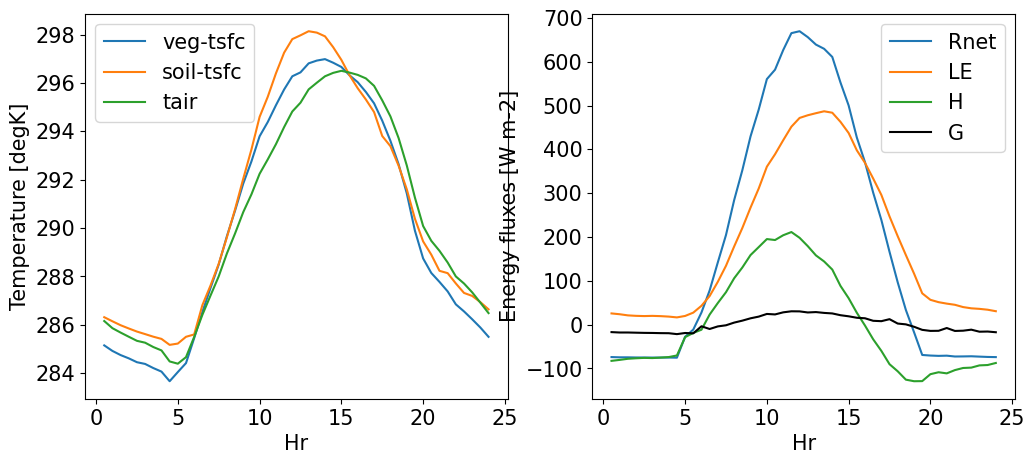

In [9]:
# Daily average
plot_daily(met, soil, veg, para);

# Compute the gradient against all the outputs

In [9]:
def implicit_func_naive(func, x_guess, para, *args):
    x_solution = fixed_point(func, x_guess, para, *args)
    return x_solution


implicit_func_naive(canoak_each_iteration, states_initial, para, *args2)

[Met(
   zL=f64[816],
   year=f64[816],
   day=f64[816],
   hhour=f64[816],
   T_air=f64[816],
   rglobal=f64[816],
   eair=f64[816],
   wind=f64[816],
   CO2=f64[816],
   P_kPa=f64[816],
   ustar=f64[816],
   Tsoil=f64[816],
   soilmoisture=f64[816],
   zcanopy=f64[816],
   lai=f64[816]
 ),
 Prof(
   co2=f64[816,100],
   Tair_K=f64[816,100],
   Told_K=f64[816,100],
   eair_Pa=f64[816,100],
   eair_old_Pa=f64[816,100],
   wind=f64[816,50],
   Tsfc=f64[816,50],
   H=f64[816,50],
   LE=f64[816,50],
   Rnet=f64[816,50],
   Ps=f64[816,50]
 ),
 Ir(
   ir_in=f64[816],
   ir_dn=f64[816,51],
   ir_up=f64[816,51],
   IR_source_sun=f64[816,50],
   IR_source_shade=f64[816,50],
   IR_source=f64[816,50],
   shade=f64[816,50],
   shade_top=f64[816,51],
   shade_bottom=f64[816,51],
   balance=f64[816,50]
 ),
 Qin(sun_abs=f64[816,50], shade_abs=f64[816,50]),
 SunShadedCan(
   Ps=f64[816,50],
   Resp=f64[816,50],
   gs=f64[816,50],
   vpd_Pa=f64[816,50],
   LE=f64[816,50],
   H=f64[816,50],
   Rnet=f64

In [10]:
derivative_implicit_naive = jacfwd(implicit_func_naive, argnums=(2,), has_aux=False)

In [11]:
jac = derivative_implicit_naive(canoak_each_iteration, states_initial, para, *args2)

# Compute the gradient using IFT
The kernel dies when trying to compute the gradient of $\frac{\partial F}{\partial \mathbf{x}}$ for all the canoak outputs. This should be avoided then.

In [10]:
Jac = jacfwd(canoak_each_iteration, argnums=0, has_aux=False)
J = Jac(states_initial, para, *args2)

: 

# Compute the gradients against only canopy LE
Thus, there is a need to compute the gradients against only part of the outputs.

In [10]:
# We first need to create a wrapper function that takes in the can.LE
args3 = args2[1:]  # skip the number of iterations
# def canoak_each_iteration_le(can_le, states_initial, para, *args):
#     can = states_initial[-1]
#     can_new = eqx.tree_at(lambda t: t.LE, can, can_le)
#     states_initial[-1] = can_new
#     states_updated = canoak_each_iteration(states_initial, para, *args)
#     return states_updated[-1].LE

In [13]:
def get_le_output(states):
    return states[-1].LE


def update_le_output(states, can_le):
    can = states[-1]
    can_new = eqx.tree_at(lambda t: t.LE, can, can_le)
    states[-1] = can_new
    return states


def implicit_func_sub_naive(
    func,
    solver,
    update_states_func,
    get_state_func,
    sub_states_guess,
    states_guess,
    para,
    *args
):
    states_guess = update_states_func(states_guess, sub_states_guess)
    states_solution = solver(func, states_guess, para, *args)
    sub_states_solution = get_state_func(states_solution)
    return sub_states_solution


can_le_initial = get_le_output(states_initial)
can_le_final = implicit_func_sub_naive(
    canoak_each_iteration,
    fixed_point,
    update_le_output,
    get_le_output,
    can_le_initial,
    states_initial,
    para,
    *args2
)

Iterations: 100


In [14]:
derivative_implicit_sub_naive = jacfwd(
    implicit_func_sub_naive, argnums=(6,), has_aux=False
)
(jac_le,) = derivative_implicit_sub_naive(
    canoak_each_iteration,
    fixed_point,
    update_le_output,
    get_le_output,
    can_le_initial,
    states_initial,
    para,
    *args2
)
jac_le.bprime[:10]

Iterations: 100


Array([442.30007116, 240.64091581, 266.21745682, 497.54163135,
       480.8612054 , 279.99320706, 349.4428598 , 348.65632129,
       374.17964786, 398.55198207], dtype=float64)

In [23]:
# # TODO -- test the calculation of the Jacobian matrix between model states
# def each_iteration_sub(iteration_func, update_states_func, get_state_func, sub_states_guess, states_guess, para, *args):
#     states_guess = update_states_func(states_guess, sub_states_guess)
#     states_solution = iteration_func(states_guess, para, *args)
#     sub_states_solution = get_state_func(states_solution)
#     return sub_states_solution

# Jac = jacfwd(each_iteration_sub, argnums=3, has_aux=False)
# J = Jac(canoak_each_iteration, update_le_output, get_le_output, can_le_initial, states_initial, para, *args2[1:])

# Compute the gradients against only canopy LE using IFT

In [15]:
@partial(jax.custom_jvp, nondiff_argnums=(0, 1, 2, 3))
def implicit_func_sub(
    iter_func,
    solver,
    update_substates_func,
    get_substate_func,
    substates_guess,
    states_guess,
    para,
    *args
):
    states_guess = update_substates_func(states_guess, substates_guess)
    states_solution = solver(iter_func, states_guess, para, *args)
    substates_solution = get_substate_func(states_solution)
    return substates_solution

In [18]:
# canoak_each_iteration(states_final, para, *args2[1:])
def each_iteration_para_test(para):
    # states1 = update_substates_func(states_final, substates_final)
    states2 = canoak_each_iteration(states_final, para, *args2[1:])
    substates2 = get_le_output(states2)
    return substates2


derivative_each_iteration = jacfwd(
    each_iteration_para_test, argnums=(0,), has_aux=False
)
(jac_le2,) = derivative_each_iteration(para)
jac_le2.bprime[:10]

Array([494.37764556, 292.7584343 , 311.62547375, 540.23471776,
       522.37392809, 339.11605709, 399.07704763, 394.35670706,
       417.72750435, 468.12666643], dtype=float64)

In [16]:
@implicit_func_sub.defjvp
def implicit_func_sub_jvp(
    iter_func, solver, update_substates_func, get_substate_func, primals, tangents
):
    substates_guess, states_guess = primals[0], primals[1]
    para, args = primals[2], primals[3:]
    tan_substates_guess, tan_states_guess = tangents[0], tangents[1]
    tan_para, tan_args = tangents[2], tangents[3:]

    states_final = solver(iter_func, states_guess, para, *args)
    substates_final = get_substate_func(states_final)

    def each_iteration_para(para):
        # states1 = update_substates_func(states_final, substates_final)
        states2 = iter_func(states_final, para, *args[1:])
        substates2 = get_substate_func(states2)
        return substates2

    def each_iteration_state(substates):
        states1 = update_substates_func(states_final, substates)
        states2 = iter_func(states1, para, *args[1:])
        substates2 = get_substate_func(states2)
        return substates2

    # Compute the Jacobian and the vectors
    _, u = jvp(each_iteration_para, (para,), (tan_para,), has_aux=False)
    # _, u = jvp(each_iteration_para, (para,), (para,), has_aux=False)
    # print(len(u))
    Jacobian_JAX = jacfwd(each_iteration_state, argnums=0, has_aux=False)
    J = Jacobian_JAX(substates_final)
    I = jnp.eye(J.shape[0])
    tangent_out = jnp.linalg.solve(I - J, u)
    # print(tangent_out)
    return (
        substates_final,
        tangent_out,
    )  # you don't need to add None, see the discussion here (https://github.com/google/jax/discussions/16871)

In [17]:
derivative_implicit_sub_fwd = jacrev(implicit_func_sub, argnums=(4, 6), has_aux=False)
jac_x, jac_para = derivative_implicit_sub_fwd(
    canoak_each_iteration,
    fixed_point,
    update_le_output,
    get_le_output,
    can_le_initial,
    states_initial,
    para,
    *args2
)
# jac_x, jac_para.alpha, jac_para.beta
jac_para.bprime[:10]

Iterations: 100


Array([494.37764556, 292.7584343 , 311.62547375, 540.23471776,
       522.37392809, 339.11605709, 399.07704763, 394.35670706,
       417.72750435, 468.12666643], dtype=float64, weak_type=True)